# IMPORT

In [35]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import time
from shapely.geometry import box
from shapely.ops import unary_union
import socket
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time
from GeometrySphere import *
import rustworkx as rw
import ast
## BASIC PARAMS
plt.rcParams.update({
    "text.usetex": False,
})

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
name = 'BOS'
grid_size = 0.02
hexagon_resolution = 8
dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))

## BASIC NEEDED OBJECTS
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
bbox = SFO_obj.bounding_box
minx, miny, maxx, maxy = bbox
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
Tij = GetODGrid(dir_geometries,str(grid_size))
lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))
VectorField = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/VectorField.csv')
Potential = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/PotentialDataFrame.csv')




mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts
Initialize Grid: 0.02
ALREADY COMPUTED


In [49]:
np.exp(0.0003055803472447064)

1.0003056270416752

# MODIFY POPULATION 

### PLOT OD

In [ ]:
import igraph as ig
import time
from matplotlib.cm import inferno
from matplotlib.colors import Normalize

# CREATE GRAPH 
ig_G = ig.Graph()
ig_G.add_vertices(grid['index'])
pos = [[row['centroidx'],row['centroidy']] for id,row in grid.iterrows()]
ig_G.vs["pos"] = pos
layout = pos
edges = [(row.origin, row.destination) for row in Tij.itertuples(index=False) if row.number_people>0]
edges_with_weights = [(row.origin, row.destination, row.number_people) for row in Tij.itertuples(index=False) if row.number_people > 0]
# Add edges to igraph graph with weights
ig_G.add_edges([(e[0], e[1]) for e in edges_with_weights])  # Add edges without weights first
ig_G.es["weights"] = [e[2] for e in edges_with_weights]  # Assign weights to edges

# DEFINE MAX/MIN WEIGHTS for CMAP
min_weight = min(ig_G.es["weights"])
max_weight = max(ig_G.es["weights"])
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in ig_G.es["weights"]]

# SELECT 5% NODES WITH HIGHER DEGREE
degrees = ig_G.degree()
sorted_nodes = sorted(range(len(degrees)), key=lambda x: degrees[x], reverse=True)
top_5_percent = int(len(degrees) * 0.001)
top_nodes = sorted_nodes[:top_5_percent]
selected_edges = [(edge.source, edge.target) for edge in ig_G.es if edge.source in top_nodes]
subgraph_edges = ig_G.subgraph_edges(selected_edges)

#BOUNDING BOX SELECTION
cmap = inferno
norm = Normalize(vmin=min_weight, vmax=max_weight)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in ig_G.es["weights"]]
bbox = SFO_obj.gdf_polygons.total_bounds
#layout_G = ig_G.layout(coords = )
# PLOT
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ig.plot(subgraph_edges, layout = ig_G.vs["pos"], bbox=(0,0,1000,1000), vertex_size=2, vertex_color='lightblue',
        edge_color=[(0, 0, 0, weight / max_weight) for weight in subgraph_edges.es["weights"]], target=ax)
#SFO_obj.gdf_polygons.plot(ax=ax, color='none', edgecolor='black')

#plt.gca().set_aspect('equal')  # Set aspect ratio to equal
#plt.gca().set_axis_off()  # Turn off axes
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Edge Weight')
#plt.title('Edges from Top 5% Nodes with Highest Degree')
plt.show()


# PLOT THE CIRCUITATION

/tmp/ipykernel_2684000/3455873392.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_x = grid['geometry'].centroid.x.mean()
/tmp/ipykernel_2684000/3455873392.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_y = grid['geometry'].centroid.y.mean()
/tmp/ipykernel_2684000/3455873392.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = grid['geometry'].centroid.distance(center_of_mass)
/tmp/ipykernel_2684000/3455873392.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-p

Index of the row closest to the center of mass:
1738
(-71.10838500000013, 42.302821) (-71.12838500000012, 42.322821) 380.60065186 260.85205825
(-71.12838500000012, 42.322821) (-71.10838500000013, 42.342821) 440.65792472 316.37347651
12.745656152399711


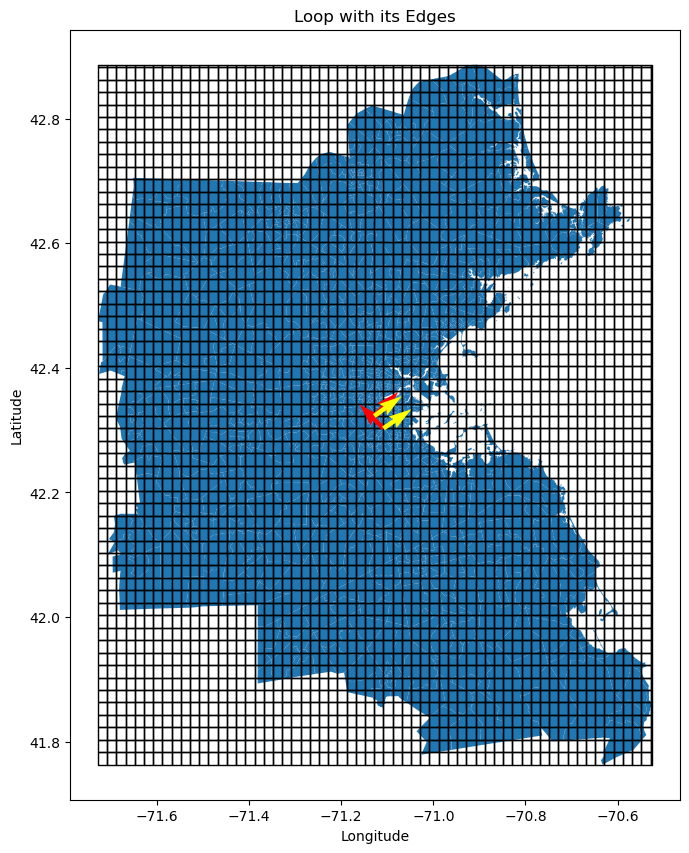

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ast
def safe_literal_eval(s):
    if ',' not in s:
        s1 = s.split(' ')
        if len(s1)==2:
            return [float(s1[0].replace('[','')),float(s1[1].replace(']',''))]      # Add commas between elements
        elif len(s1)!=2:
            s1 = s.split('  ')
            if len(s1) ==2:
                return [float(s1[0].replace('[','')),float(s1[1].replace(']',''))]      # Add commas between elements
            elif len(s1)!=2:
                s1 = s.split('   ')
                return [float(s1[0].replace('[','')),float(s1[1].replace(']',''))]      # Add commas between elements
    else:
        try:
            return ast.literal_eval(s)
        except SyntaxError:
            # Handle SyntaxError here
            print("SyntaxError: Invalid syntax in the input string")
            return None

def GetCenterMapIdx(grid):
    mean_x = grid['geometry'].centroid.x.mean()
    mean_y = grid['geometry'].centroid.y.mean()
    # Create a Point geometry for the center of mass
    center_of_mass = Point(mean_x, mean_y)
    distances = grid['geometry'].centroid.distance(center_of_mass)
    # Find the index of the row with the minimum distance
    closest_row_index = distances.idxmin()
    print("Index of the row closest to the center of mass:")
    print(closest_row_index)
    return closest_row_index

def QuiverEdge(ax,coordinates,index2choose,color):
    for i in range(len(coordinates)-1):
        x1 = coordinates[i]
        x2 = coordinates[i+1] 
        if i in index2choose:
            ax.quiver(x1[0], x1[1],x2[0] - x1[0],x2[1] - x1[1], color=color, linewidth=2)


def CreateListIndicesSquareLoop(startIdx,n_rows):
    return [startIdx -1,startIdx,startIdx + n_rows,startIdx + n_rows -1]

def CreateClosedLoopSquare(grid,startIdx,n_rows,VectorField):
    indicesDF_loop = CreateListIndicesSquareLoop(startIdx,n_rows)
    LoopCircuit = []
    LoopVF = []
    for i in range(len(indicesDF_loop)-1):
        LoopCircuit.append(list(grid['geometry'][indicesDF_loop[i]].boundary.coords)[i:i+1])
        LoopVF.append(list(safe_literal_eval(VectorField['Ti'][indicesDF_loop[i]]))) 
    LoopVF.append(list(safe_literal_eval(VectorField['Ti'][indicesDF_loop[i+1]]))) 
    return LoopCircuit,LoopVF

def QuiverCircuitation(LoopCircuit,LoopVF,ax):
    Circuitation = 0
    for i in range(len(LoopCircuit)-1):
        x1 = LoopCircuit[i][0]
        x2 = LoopCircuit[i+1][0]
        vx = LoopVF[i][0]
        vy = LoopVF[i][1]
        print(x1,x2,vx,vy)
        Circuitation += (x2[0] - x1[0])*vx + (x2[1] - x1[1])*vy
        ax.quiver(x1[0], x1[1],x2[0] - x1[0],x2[1] - x1[1], color='red', linewidth=2)
        ax.quiver(x1[0], x1[1],vx,vy, color='yellow', linewidth=2)
    return Circuitation



closest_row_index = GetCenterMapIdx(grid)
## GET THE NUMBER OF ROW AND COLS FOR YOUR GRID (It depends on the resolution)
n_rows = 57
n_cols = 61

fig, ax = plt.subplots(figsize=(10, 10))
#indices = [True if (i>(closest_row_index -3) & i<(closest_row_index + 3)) or (i>(closest_row_index +n_rows-3) and i<(closest_row_index +n_rows + 3))   else False for i,row in SFO_obj.gdf_polygons.iterrows()]
#gdf_plot = SFO_obj.gdf_polygons.loc[indices] 
#grid_plot = grid.loc[indices]
SFO_obj.gdf_polygons.plot(ax = ax)
grid.plot(ax=ax, facecolor='none', edgecolor='black')  # Plot the grid without filling
LoopCircuit,LoopVF = CreateClosedLoopSquare(grid,closest_row_index,n_rows,VectorField)
Circuitation = QuiverCircuitation(LoopCircuit,LoopVF,ax)
print(Circuitation)
#loop_edges0 = grid['geometry'][closest_row_index -1].boundary
#loop_edges1 = grid['geometry'][closest_row_index].boundary
#loop_edges2 = grid['geometry'][closest_row_index + n_rows].boundary
#loop_edges3 = grid['geometry'][closest_row_index + n_rows -1].boundary
#coordinates0 = list(loop_edges0.coords)
#coordinates1 = list(loop_edges1.coords)
#coordinates2 = list(loop_edges2.coords)
#coordinates3 = list(loop_edges3.coords)
#QuiverEdge(ax,coordinates0,[0,1],'green')
#QuiverEdge(ax,coordinates1,[1,2],'red')
#QuiverEdge(ax,coordinates2,[2,3],'yellow')
#QuiverEdge(ax,coordinates3,[3,0],'orange')
    
plt.title('Loop with its Edges')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [48]:
grid.loc[grid['population']>0]

,i,j,centroidx,centroidy,area,index,population,geometry
16,0,16,-71.718385,42.092821,1.564818,16,7.304329,"POLYGON ((-71.72839 42.10282, -71.70839 42.102..."
17,0,17,-71.718385,42.112821,1.564818,17,41.968938,"POLYGON ((-71.72839 42.12282, -71.70839 42.122..."
18,0,18,-71.718385,42.132821,1.564818,18,0.509933,"POLYGON ((-71.72839 42.14282, -71.70839 42.142..."
31,0,31,-71.718385,42.392821,1.564818,31,0.259157,"POLYGON ((-71.72839 42.40282, -71.70839 42.402..."
32,0,32,-71.718385,42.412821,1.564818,32,252.825517,"POLYGON ((-71.72839 42.42282, -71.70839 42.422..."
...,...,...,...,...,...,...,...,...
3371,59,8,-70.538385,41.932821,1.661957,3371,206.367176,"POLYGON ((-70.52839 41.92282, -70.54839 41.922..."
3424,60,4,-70.526976,41.852821,0.234302,3424,35.125121,"POLYGON ((-70.52557 41.84282, -70.52839 41.842..."
3425,60,5,-70.526976,41.872821,0.234302,3425,22.473927,"POLYGON ((-70.52557 41.86282, -70.52839 41.862..."
3426,60,6,-70.526976,41.892821,0.234302,3426,12.843727,"POLYGON ((-70.52557 41.88282, -70.52839 41.882..."


In [42]:
LoopCircuit

[[(-71.10838500000013, 42.302821)],
 [(-71.12838500000012, 42.322821)],
 [(-71.10838500000013, 42.342821)]]

[['[',
  '3',
  '8',
  '0',
  '.',
  '6',
  '0',
  '0',
  '6',
  '5',
  '1',
  '8',
  '6',
  ' ',
  '2',
  '6',
  '0',
  '.',
  '8',
  '5',
  '2',
  '0',
  '5',
  '8',
  '2',
  '5',
  ']'],
 ['[',
  '4',
  '4',
  '0',
  '.',
  '6',
  '5',
  '7',
  '9',
  '2',
  '4',
  '7',
  '2',
  ' ',
  '3',
  '1',
  '6',
  '.',
  '3',
  '7',
  '3',
  '4',
  '7',
  '6',
  '5',
  '1',
  ']'],
 ['[',
  '8',
  '8',
  '.',
  '1',
  '5',
  '9',
  '2',
  '0',
  '2',
  '9',
  '6',
  ' ',
  ' ',
  '5',
  '.',
  '6',
  '9',
  '4',
  '4',
  '9',
  '2',
  '6',
  '3',
  ']']]

In [ ]:
from matplotlib.cm import inferno
from matplotlib.colors import Normalize

min_weight = min(ig_G.es["weights"])
max_weight = max(ig_G.es["weights"])
cmap = inferno
# Normalize the weights to map them to the range [0, 1]
norm = Normalize(vmin=min_weight, vmax=max_weight)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in ig_G.es["weights"]]
bbox = SFO_obj.gdf_polygons.total_bounds
# Plot the graph
visual_style = {
    "vertex_size": 10,
    "vertex_color": "lightblue",
    "edge_width": normalized_weights,  # Use normalized weights as edge widths
    "edge_color": "gray",
}


fig,ax = plt.subplots(1,1,figsize = (10,10))
t0 = time.time()
ig.plot(ig_G, layout=ig_G.vs["pos"], bbox=bbox, vertex_size=2, vertex_color='lightblue', 
        edge_color=[(0, 0, 0, weight / max_weight) for weight in ig_G.es["weights"]], target=ax)
SFO_obj.gdf_polygons.plot(ax=ax, color='none', edgecolor='black')

plt.gca().set_aspect('equal')  # Set aspect ratio to equal
plt.gca().set_axis_off()  # Turn off axes
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Edge Weight')
t1 = time.time()
print('Time to Plot: ',t1-t0)
plt.title('Graph of Grid with Number of People between Grid Nodes and Boston Polygons')
plt.show()

In [39]:
len(Tij.loc[Tij['number_people']>0])

131478

In [26]:
min(ig_G.es['weights'])

0

In [ ]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for idx, row in grid.iterrows():
    G.add_node(row['index'], pos=[row['centroidx'],row['centroidy']])
pos = {row['index']:(row['centroidx'],row['centroidy']) for id,row in grid.iterrows()}
# Add edges with number of people as edge weight
for idx, row in Tij.iterrows():
    G.add_edge(row['origin'], row['destination'], weight=row['number_people'])

# Plot graph
pos = nx.get_node_attributes(G, 'pos')
weights = [G[u][v]['weight'] for u, v in G.edges()]
cmap = plt.cm.inferno

from rustworkx.visualization import mpl_draw
cmap = plt.cm.inferno

rw_G = rw.PyGraph()
for node in G.nodes:
    rw_G.add_node(node)

listedges = [(edge[0],edge[1],G[edge[0]][edge[1]]['weight']) for edge in G.edges()]
rw_G.add_edges_from(listedges)
# Plot the igraph graph
fig,ax = plt.subplots(1,1,figsize = (10,10))
mpl_draw(rw_G)
#rw_G.plot(ax=ax, layout='circle', vertex_color='lightblue', edge_color='gray', vertex_label_dist=1.5, bbox=(300, 300))

# Plot Boston polygons
SFO_obj.gdf_polygons.plot(ax=plt.gca(), color='none', edgecolor='black')

#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), fraction=0.025, pad=0.04)
#cbar.set_label('Number of People')
plt.title('Graph of Grid with Number of People between Grid Nodes and Boston Polygons')
plt.show()

In [ ]:
from rustworkx.visualization import mpl_draw
cmap = plt.cm.inferno

rw_G = rw.PyGraph()
for node in G.nodes:
    rw_G.add_node(node)

listedges = [(edge[0],edge[1],G[edge[0]][edge[1]]['weight']) for edge in G.edges()]
rw_G.add_edges_from(listedges)
# Plot the igraph graph
fig,ax = plt.subplots(1,1,figsize = (10,10))
mpl_draw(rw_G)
#rw_G.plot(ax=ax, layout='circle', vertex_color='lightblue', edge_color='gray', vertex_label_dist=1.5, bbox=(300, 300))

# Plot Boston polygons
SFO_obj.gdf_polygons.plot(ax=plt.gca(), color='none', edgecolor='black')

#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), fraction=0.025, pad=0.04)
cbar.set_label('Number of People')
plt.title('Graph of Grid with Number of People between Grid Nodes and Boston Polygons')
plt.show()

In [50]:
print('Average Population in Inhabited grids: ',np.mean(grid['population'].loc[np.where(grid['population']>0)]))
print('Number of Inhabited grids: ',len(grid['population'].loc[np.where(grid['population']>0)]))
print('Number of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'].loc[np.where(grid['population']>0)])]))
print('Fraction of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'].loc[np.where(grid['population']>0)])])/len(grid['population'].loc[np.where(grid['population']>0)]))
print('Average Population in Non-Inhabited grids: ',np.mean(grid['population']))
print('Number of Non-Inhabited grids: ',len(grid['population']))
print('Number of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'])]))
print('Fraction of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'])])/len(grid['population']))
print('Fraction of Inhabited/Non-Inhabited grids: ',len(grid['population'].loc[np.where(grid['population']>0)])/len(grid['population']))
# CHOICE AREA TO STUDY: JUST POPULATED
RestrictedPop = grid['population'].loc[np.where(grid['population']>0)]
# MIN and MAX Pop -> to set the interval for the exponential distribution
MinPop = min(RestrictedPop)
MaxPop = max(RestrictedPop)
# Resolution 
bins = 500
print('Resolution in Population (number of people): ',(MaxPop - MinPop)/bins)
print('Minimum Population Considered: ',MinPop)
print('Maximum Population Considered: ',MaxPop)


Average Population in Inhabited grids:  1960.5355515759077
Number of Inhabited grids:  2319
Number of cells that have less then average population:  556
Fraction of cells that have less then average population:  0.2397585166019836
Average Population in Non-Inhabited grids:  1307.5875594203421
Number of Non-Inhabited grids:  3477
Number of cells that have less then average population:  834
Fraction of cells that have less then average population:  0.23986194995685936
Fraction of Inhabited/Non-Inhabited grids:  0.6669542709232097
Resolution in Population (number of people):  66.88890811188139
Minimum Population Considered:  5.0209312250844166e-05
Maximum Population Considered:  33444.454106150006


### Exponential Distribution Generation Points

In [52]:
# Creation Exponential Distr
PopBins = np.linspace(MinPop,MaxPop,bins)
m0 = np.mean(RestrictedPop)
PopExpo =  np.exp(-PopBins/m0)/np.sum(np.exp(-PopBins/m0))
AverageExpo = np.sum(PopBins*PopExpo)
IdxBinMean = np.where(PopBins<AverageExpo)[0]
CumulativePopExpo = np.cumsum(PopExpo)
print('m0: ',m0)
print('Average Expo: ',AverageExpo)
print('m0 - AverageExpo: ',m0 - AverageExpo)
#print('Cumulative Population Expo: ',CumulativePopExpo)
print('Cumulative at Average: ',CumulativePopExpo[max(IdxBinMean)])


m0:  1960.5355515759077
Average Expo:  1927.2137944051556
m0 - AverageExpo:  33.32175717075211
Cumulative at Average:  0.6289414198712806


# Power Law Distribution Fitted Generation Points

In [51]:
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitPlMass.json','r') as f:
    fitplM = json.load(f)
# Data
PopPlBins = np.linspace(MinPop,MaxPop,bins)
PopPl = 11*PopPlBins**(-1.83) 
#PopPl = fitplM['A']*PopPlBins**(fitplM['b']) 
PopPl = PopPl/np.sum(PopPl)
AveragePl = np.sum(PopPl*PopPlBins)
IdxBinsMeanData = min(np.where(PopPl<AveragePl)[0])
CumulativePopData = np.cumsum(PopPl)
print('Average Data: ',np.sum(PopPl*PopPlBins))
print('Teorethical Cumulative at average: ',1/(-1.83 + 1)*(max(PopPlBins)**(-1.83 + 2)-min(PopPlBins)**(-1.83 + 2)))
print('Cumulative at Average: ',CumulativePopData[IdxBinsMeanData])



Average Data:  5.0214110381853496e-05
Teorethical Cumulative at average:  -6.856486584558129
Cumulative at Average:  0.9999999999948642


# Data

In [53]:
binsd = 40
PopData,PopDataBins = np.histogram(RestrictedPop,binsd)
#PopDataBins = np.array([PopDataBins[i] + PopDataBins[i + 1] for i in range(len(PopDataBins)-1)])
PopData = PopData/np.sum(PopData)
AverageData = np.sum(PopData*PopDataBins[:-1])
IdxBinsMeanData = max(np.where(PopData<AverageData)[0])
CumulativePopData = np.cumsum(PopData)
print('Average Data: ',AverageData)
print('Cumulative at Average: ',CumulativePopData[IdxBinsMeanData])


Average Data:  1590.738852438833
Cumulative at Average:  1.0


### Comparison Expo Data

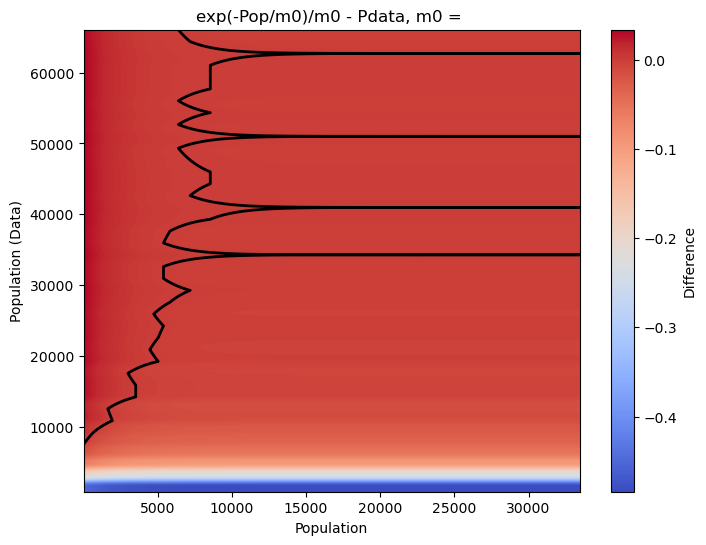

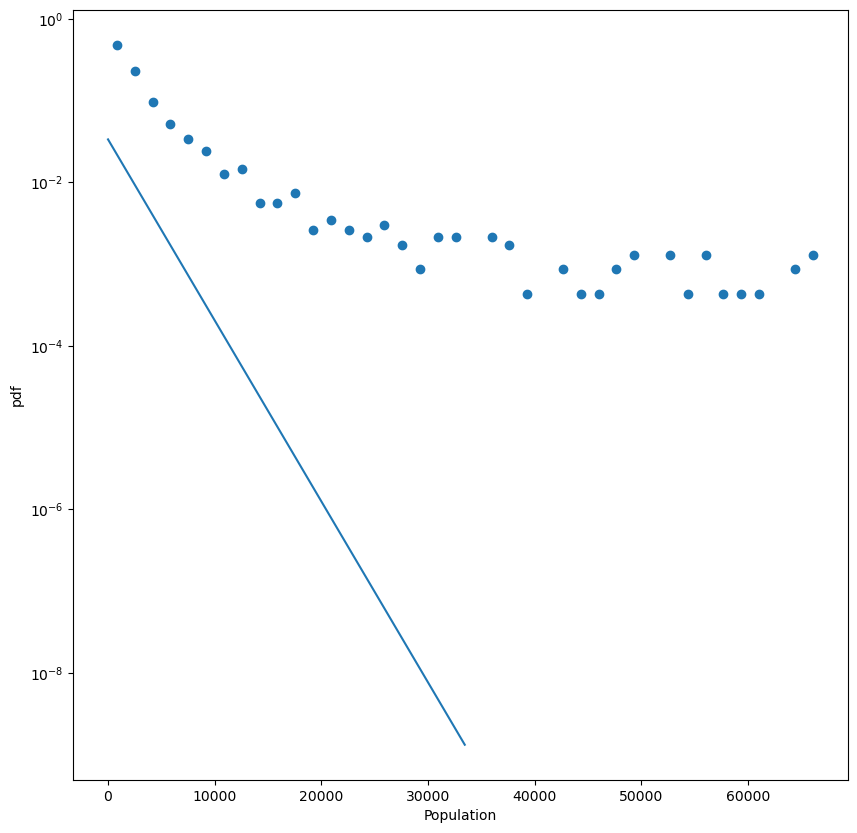

In [ ]:
PopExpo_mesh, PopData_mesh = np.meshgrid(PopExpo, PopData/np.sum(PopData))
heatmap_data = PopExpo_mesh - PopData_mesh
X, Y = np.meshgrid(PopBins, PopDataBins)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='coolwarm', aspect='auto', origin='lower', extent=[PopBins[0], PopBins[-1], PopDataBins[0], PopDataBins[-1]])
plt.colorbar(label='Difference')

contour = plt.contour(X, Y, heatmap_data, levels=[0], colors='black', linewidths=2)
#plt.clabel(contour, inline=True, fontsize=10)
plt.xlabel('Population')
plt.ylabel('Population (Data)')
plt.title('exp(-Pop/m0)/m0 - Pdata, m0 = '.format(round(m0,2)))
plt.show()


fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(PopDataBins,PopData,label = 'Data')
ax.plot(PopBins,PopExpo,label = 'Expo')
ax.set_xlabel('Population')
ax.set_ylabel('pdf')
ax.set_yscale('log')
plt.show()



### Comparison PowerLaw Expo

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(PopPlBins,np.cumsum(PopPl),label = 'Data')
ax.plot(PopBins,np.cumsum(PopExpo),label = 'Expo')
IdxChange = min(np.where(PopPl>PopExpo)[0])
ax.axvline(PopPlBins[IdxChange])
ax.text(PopPlBins[IdxChange] + 500, 0, f'P* = {PopPlBins[IdxChange]:.2f}', ha='right', va='bottom', color='black')
ax.set_xlabel('Population')
ax.set_ylabel('pdf')
plt.show()

fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(PopPlBins,PopPl,label = 'Data')
ax.plot(PopBins,PopExpo,label = 'Expo')
ax.axvline(PopPlBins[IdxChange])
ax.text(PopPlBins[IdxChange] + 500, 0, f'P* = {PopPlBins[IdxChange]:.2f}', ha='right', va='bottom', color='black')
ax.set_xlabel('Population')
ax.set_ylabel('pdf')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


# Modify polycenters


In [33]:
def generate_multivariate_gaussians(k,d,n_per_center):
    means = np.random.randn(k,d)
    covariances = np.zeros((k,d,d))
    for i in range(k):
        A = np.random.randn(d,d)
        covariances[i] = np.dot(A,A.T)
    print(covariances)
    points = []
    for i in range(k):
        points.append(np.random.multivariate_normal(means[i],covariances[i],n_per_center))
    points = np.concatenate(points,axis = 0)
    return points

def generate_multivariate_gaussians(k, d, n_per_center):
    means = np.random.randn(k, d)
    covariances = np.zeros((k, d, d))
    for i in range(k):
        A = np.random.randn(d, d)
        covariances[i] = np.dot(A, A.T)
    print(covariances)
    points = []
    for i in range(k):
        cloud_points = np.random.multivariate_normal(means[i], covariances[i], n_per_center)
        for j in range(i):
            mask = np.logical_and(np.all(cloud_points >= means[j], axis=1), np.all(cloud_points <= means[j], axis=1))
            cloud_points = cloud_points[~mask]
        points.append(cloud_points)
    
    points = np.concatenate(points, axis=0)
    return points


In [72]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

## TODO: Set the Number of People inside the zone: In a model this can be seen as perturbation 

def TotalPopulation(grid):
    return np.sum(grid['population'])

def FilterPopulation(grid):
    '''
        Filters population and add reshape population
    '''
    assert 'population' in grid.columns, 'The grid does not have a population column'
    assert 'centroidx' in grid.columns, 'The grid does not have a centroidx column'
    assert 'centroidy' in grid.columns, 'The grid does not have a centroidy column'
    grid['reshaped_population']= np.zeros(len(grid))
    filtered_grid = grid[grid['population'] != 0]

    # Extract the population, centroidx, and centroidy values
    population = filtered_grid['population'].values
    centroidx = filtered_grid['centroidx'].values
    centroidy = filtered_grid['centroidy'].values
    index = filtered_grid.index
    return population,centroidx,centroidy,index,filtered_grid

population,centroidx,centroidy,index,filtered_grid = FilterPopulation(grid)


# SET NUMBER OF CENTERS
k = 1
# SET SPATIAL DIMENSION
d = 2
# SET NUMBER POINTS PER CENTER
n_per_center = int(TotalPopulation(grid)/k) # In this way I do not redistribute inhommogeneously the population

# Generate multivariate Gaussian distributions
means = np.mean(np.column_stack((centroidx, centroidy)), axis=0)
covariances = np.zeros((k, d, d))
points = []
indices = []
for i in range(k):
    covariances[i] = np.eye(d)  # Assuming identity covariance matrix for simplicity
    points.append(np.random.multivariate_normal(means, covariances[i], n_per_center))
    for j in range(n_per_center):
        indices.append(index[i])
points = np.concatenate(points, axis=0)

# Assign population to each grid from the center
for point in points:
    # Find the 8 smallest distances to the grids
    distances = np.linalg.norm(np.column_stack((centroidx, centroidy)) - point, axis=1)
    smallest_distances_idx = np.argsort(distances)[:8]
    # Check if the generated point is inside the polygons of the 8 nearest grids
    for idx in smallest_distances_idx:
        if filtered_grid['geometry'].iloc[idx].contains(Point(point)):
            # Increment the population of the nearest grid by 1
            filtered_grid.iloc[idx, filtered_grid.columns.get_loc('reshaped_population')] += 1

# Merge the updated grid with the original grid
merged_grid = grid.merge(filtered_grid, on=['centroidx', 'centroidy'], how='left')

# Drop unnecessary columns
merged_grid = merged_grid.drop(columns=['geometry_y'])

# Rename the 'population_x' column to 'population'
merged_grid = merged_grid.rename(columns={'population_x': 'population'})

# The resulting GeoDataFrame 'merged_grid' will have the updated population values for the grids with population different from 0.


Index([  16,   17,   18,   31,   32,   33,   34,   35,   36,   37,
       ...
       3366, 3367, 3368, 3369, 3370, 3371, 3424, 3425, 3426, 3427],
      dtype='int64', length=2319)


KeyboardInterrupt: 

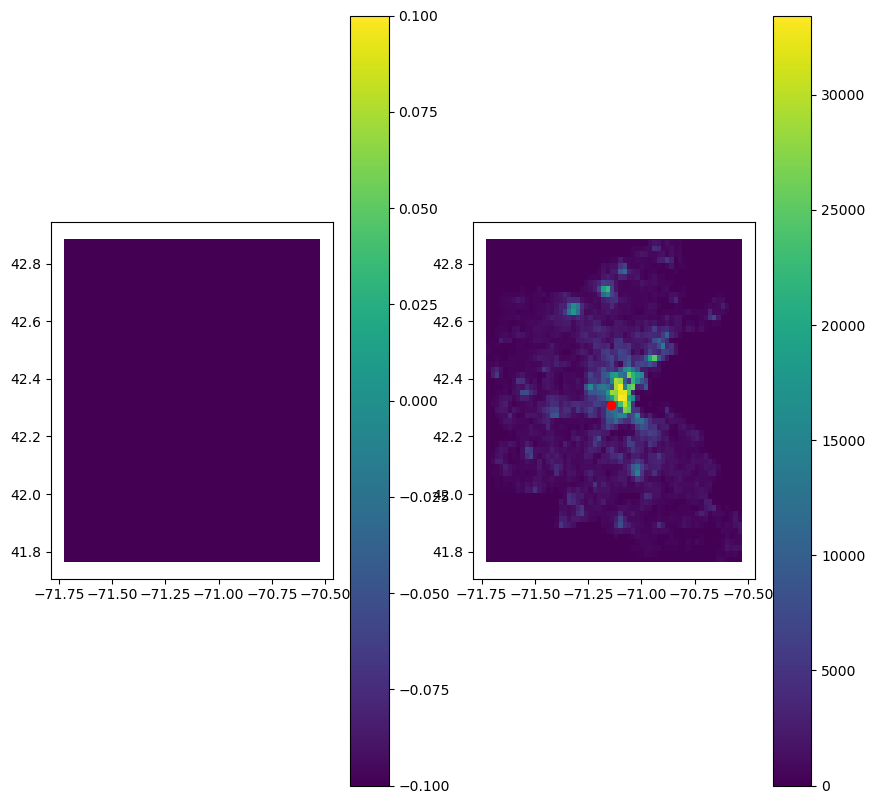

In [69]:
merged_grid['geometry'] = merged_grid['geometry_x']
#merged_grid.plot(column='population', cmap='viridis', legend=True)
fig,ax = plt.subplots(1,2,figsize = (10,10))
grid.plot('reshaped_population', cmap='viridis', legend=True,ax = ax[0])
grid.plot('population', cmap='viridis', legend=True,ax = ax[1])
ax[1].scatter(means[0],means[1],color = 'red')

(300000, 2)


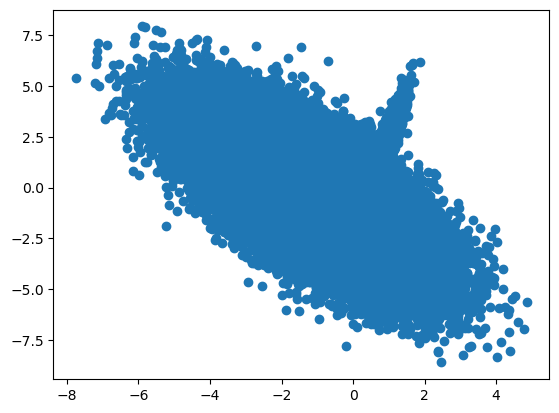

In [32]:
import matplotlib.pyplot as plt
import numpy as np
k = 3
d = 2
n_per_center = 100000
points = generate_multivariate_gaussians(k,d,n_per_center)
print(np.shape(points))
plt.scatter(points[:,0],points[:,1])

In [6]:

def ComputeVectorFieldModified(Tij,df_distance):
    Tij['vector_flux'] = df_distance['dir_vector'].apply(lambda x: parse_dir_vector(x) ) * Tij['number_people']

    # Create VectorField DataFrame
    VectorField = pd.DataFrame(index=Tij['(i,j)D'].unique(), columns=['(i,j)', 'Ti', 'Tj'])
    Tj_values = Tij.groupby('(i,j)D')['vector_flux'].sum()
    VectorField['Tj'] = Tj_values

    # Calculate 'Ti' values
    Ti_values = Tij.groupby('(i,j)O')['vector_flux'].sum()
    VectorField['Ti'] = Ti_values
    VectorField['index'] = VectorField.index
    VectorField['(i,j)'] = VectorField['index']
    VectorField['index'] = VectorField.index
    VectorField.reset_index(inplace=True)
    return VectorField

def fill_zeros_with_fit(vector):
    # Find indices of non-zero values
    non_zero_indices = np.where(vector != 0)[0]
    
    # Use non-zero indices to fit values
    fitted_values = np.interp(np.arange(len(vector)), non_zero_indices, vector[non_zero_indices])
    
    # Replace zeros with fitted values
    filled_vector = np.where(vector == 0, fitted_values, vector)
    
    return filled_vector

def IdxGrid2IdxBin(pop, idxgrid, bins):
    mask = [(pop[idxgrid] >= bins[j]) and (pop[idxgrid] <= bins[j + 1]) for j in range(len(bins) - 1)]
    indices = [j for j, m in enumerate(mask) if m]
    return indices

def UpdatePolycentricPop(population,index,index1,NCell2DividePop):
    population[index1] += population[index]/NCell2DividePop  
    population[index] = population[index]/NCell2DividePop
    return population

def UpdateMonocentricPop(population,index,index1):
    population[index1] += population[index]
    population[index] = 0
    return population

def ReassignPopulationRandomly(grid, m0, r0, N, transform_toward = 'monocentric',geometricl_influence = False):
    '''
        Input:
            grid: Grid with info about population and distance
            m0: Parameter, 66% of grid, have mass in the interval [0,m0]
            r0: Parameter, 66% of grid, have distance in the interval [0,r0]
            N: Number of repetitions 
            transfrom_toward: 'monocentric', 'policentric'
        Output:
            population: np.array Population Modified 
            evolution_mean: np.array -> Since during the population is redestributed then the mean changes as the number of grids that have population changes
            evolution_number_centers: np.array -> Number of centers that change
            population_moved: float: Total Population has moved after the simulation
            evolution_population_moved: np.array How much population is moved in the ITERATIONS
        This function reassign population according to ModifyPop principles.
        Takes the probability to reassign depending on the distance from the center.

    '''    
    evolution_mean = []
    evolution_number_centers = []
    fraction_times_change_pop = 0
    population_moved = 0
    evolution_population_moved = []
    # POPULATION
    population = grid['population'].copy()
    center_idx = np.argmax(population)
    coords_center = np.array([grid['centroidx'][center_idx],grid['centroidy'][center_idx]]) 
    indices = np.where(population > 0)[0]  # Step 1
    n,bins = np.histogram(population,500)
    # GET POPULATION DISTRIBUTION
    p = n/np.sum(n)
    p1 = fill_zeros_with_fit(p)
    for _ in range(N):
        # CONSIDER JUST THE GRIDS WITH POPULATION>0 
        indices = np.where(population > 0)[0]  
        # PICK RANDOMLY THE GRID WHOSE POPULATION WILL BE SET TO 0 if satisfy the right criterium
        index = np.random.choice(indices)
        # FIND THE BIN in which it lies
        # NOTE: Since index is in indices I must look at population[indices] -> filtered with just populated grids 
        assert index in indices
        binidx = IdxGrid2IdxBin(population[indices], index, bins)[0]

        # TAKE PROBABILITY OF THE MEASURED POPULATION 
        pl_value = p1[binidx]
        # TAKE THE FAKE DISTRIBUTION
        exp_value = np.exp(-bins[binidx]/m0)

        # EVOLUTION AVERAGE & NUMBER CENTERS
        # NOTE: DEBUGGING PORPOUSES -> Takes track of the population distribution
        evolution_mean.append(np.mean(population[indices]))
        evolution_number_centers.append(len(indices))
        if transform_toward == 'monocentric':
            # REASSIGN THE 'LOW POPULATED GRIDS'
            if pl_value > exp_value:  
#            print('Mass extracted: ',mass_extracted)
#            print('Expo prob: ',exp_value)
#            print('Power Law prob: ',pl_value)
#            print('Population going 0: ',population[index])
                fraction_times_change_pop +=1     
                # CHOOSE THE REASSIGNED GRID AMONG POPULATED GRIDS       
                index1 = np.random.choice(indices)
                while(population[index1]==0):
                    index1 = np.random.choice(indices)
                    # NOTE: IMPOSE that the reassignment to stay close to the center.
                    if geometricl_influence:
                        while(np.exp(-r/r0)>p):
                            index1 = np.random.choice(indices)
                            center_extracted = np.array([grid['centroidx'][index1],grid['centroidy'][index1]])
                            r = ProjCoordsTangentSpace(coords_center[0],coords_center[1],center_extracted[0],center_extracted[1])
                        population_moved += population[index]
                        evolution_population_moved.append(population_moved)
                        population = UpdateMonocentricPop(population,index,index1)                    
                    else:
                        population_moved += population[index]
                        evolution_population_moved.append(population_moved)
                        population = UpdateMonocentricPop(population,index,index1)
#            print('Population increased: ',population[index1])
            else:
                evolution_population_moved.append(population_moved)
        if transform_toward == 'polycentric':
            # REASSIGN THE 'LOW POPULATED GRIDS'
            if pl_value < exp_value:  
                fraction_times_change_pop +=1     
                # CHOOSE THE REASSIGNED GRID AMONG POPULATED GRIDS       
                index1 = np.random.choice(indices)
                # AVG POPULATION TO CONTROL HOW MANY POP TO SPREAD TO
                avg_pop = np.mean(population[indices])
                NCell2DividePop= int(population[index]/avg_pop)
                # DIVIDE THE POPULATION IN NCell2DividePop Parts so that the distribution will be more spreaded
                for Cell in range(NCell2DividePop):
                    while(population[index1]==0):
                        index1 = np.random.choice(indices)
                        # NOTE: IMPOSE that the reassignment to stay close to the center.
                        if geometricl_influence:
                            while(np.exp(-r/r0)>p):
                                index1 = np.random.choice(indices)
                                center_extracted = np.array([grid['centroidx'][index1],grid['centroidy'][index1]])
                                r = ProjCoordsTangentSpace(coords_center[0],coords_center[1],center_extracted[0],center_extracted[1])
                            population_moved += population[index]/NCell2DividePop
                            evolution_population_moved.append(population_moved)
                            population = UpdatePolycentricPop(population,index,index1,NCell2DividePop)
                        else:
                            # MOVE THE FRACTION OF PEOPLE THAT ARE MORE THEN AVERAGE TOWARD AVERAGE
                            population_moved += population[index]/NCell2DividePop
                            evolution_population_moved.append(population_moved)
                            population = UpdatePolycentricPop(population,index,index1,NCell2DividePop)

    #            print('Population increased: ',population[index1])
            else:
                evolution_population_moved.append(population_moved)
            
    print('Fraction Changed: ',fraction_times_change_pop/N)
    print('Total Grids Changed: ',fraction_times_change_pop)
    print('Total number Population Moved: ',population_moved)
    return population,evolution_mean,evolution_number_centers,population_moved,evolution_population_moved


3010.0008695535003
16254.004695588903
28494.674898439804


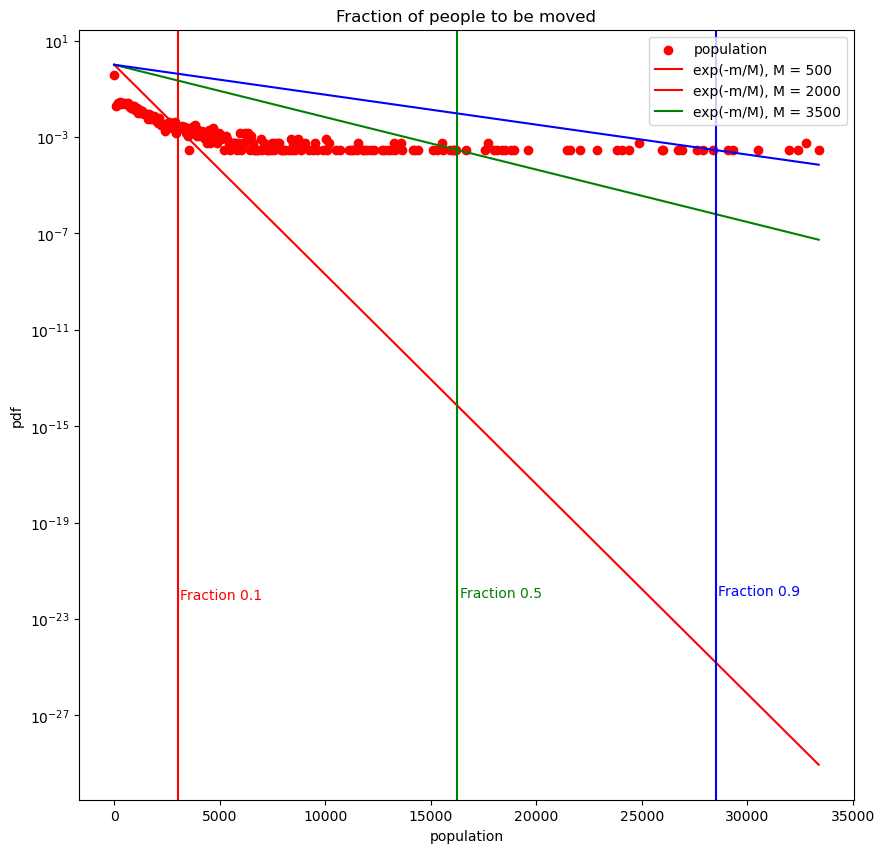

Final 0.0015763106331130763


In [180]:
def PlotComparisonMass2ExpDistr(population,a,partition_population = 500,shift = 2000):
    '''
        Given a population distribution and exponential characteristics:
            - Determines the fraction of grids that have less population then 
    '''
    n,bins = np.histogram(population,partition_population)
    x = -np.linspace(bins[0],bins[-1],partition_population)

n,bins = np.histogram(grid['population'],500)
shift = 2000
x = -np.linspace(bins[0],bins[-1],500)
deltax = bins[1] - bins[0]
expa = []
EvolutionExpNumber = 3
colordict = colors = ["red","green","blue","yellow"]

legend = ['population']
p = n/np.sum(n)
p1 = fill_zeros_with_fit(p)
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(bins[:-1],p,color = 'red')
i = 0
for a in np.linspace(500,3500,EvolutionExpNumber):
    Aa = 1/(1-np.exp(-deltax/a))
    exp_ = np.exp(x/a)
    abs_diff = np.abs(exp_ - p1)
#    print('exp: ',exp_)
#    print('Diff: ',abs_diff)

    # Find the index of the minimum difference
    min_diff_index = np.argmin(abs_diff)
#    print('A: ',Aa,' deltax: ',deltax/a,' sum(exp): ',np.sum(exp_),' Error approx: ',np.sum(exp_)-Aa)
    # GET POPULATION DISTRIBUTION
    ax.plot(bins[:-1],exp_,label = a,color = colors[i])#/(bins[-1]-bins[0])
    ax.axvline(bins[min_diff_index],color = colors[i])
    plt.text(bins[min_diff_index] + 2*shift , (i+5)*(10**(-23)), f'Fraction {round(bins[min_diff_index]/bins[-1],1)}', ha='right', va='bottom', color=colors[i])
#    plt.axhline(y=(i+3)*(10**(-23)), xmin=0, xmax=bins[min_diff_index], color=colors[i], linestyle='--')

    print(bins[min_diff_index])
    legend.append('exp(-m/M), M = {}'.format(int(a)))
    i += 1
plt.legend(legend)    
plt.yscale('log')
ax.set_xlabel('population')
ax.set_ylabel('pdf')
ax.set_title('Fraction of people to be moved')
plt.savefig('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/FractionMoved.png',dpi = 200)
plt.show()
print('Final',np.sum(exp_)/(bins[-1]-bins[0]))

#plt.scatter(np.linspace(1,bins[-1],EvolutionExpNumber),expa)
#plt.xscale('log')
#plt.yscale('log')
#plt.show()


In [188]:
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitPlMass.json','r') as f:
    fitplM = json.load(f)

Fraction Changed:  0.02
Total Grids Changed:  40
Total number Population Moved:  0


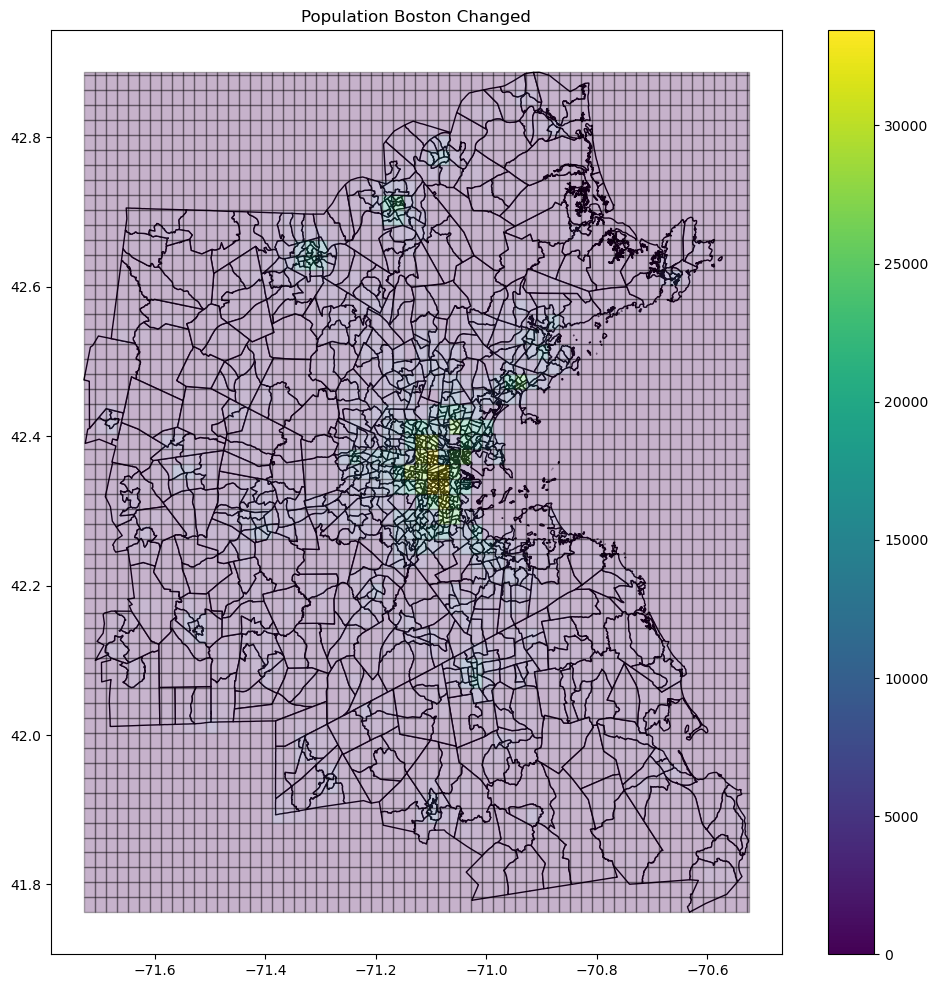

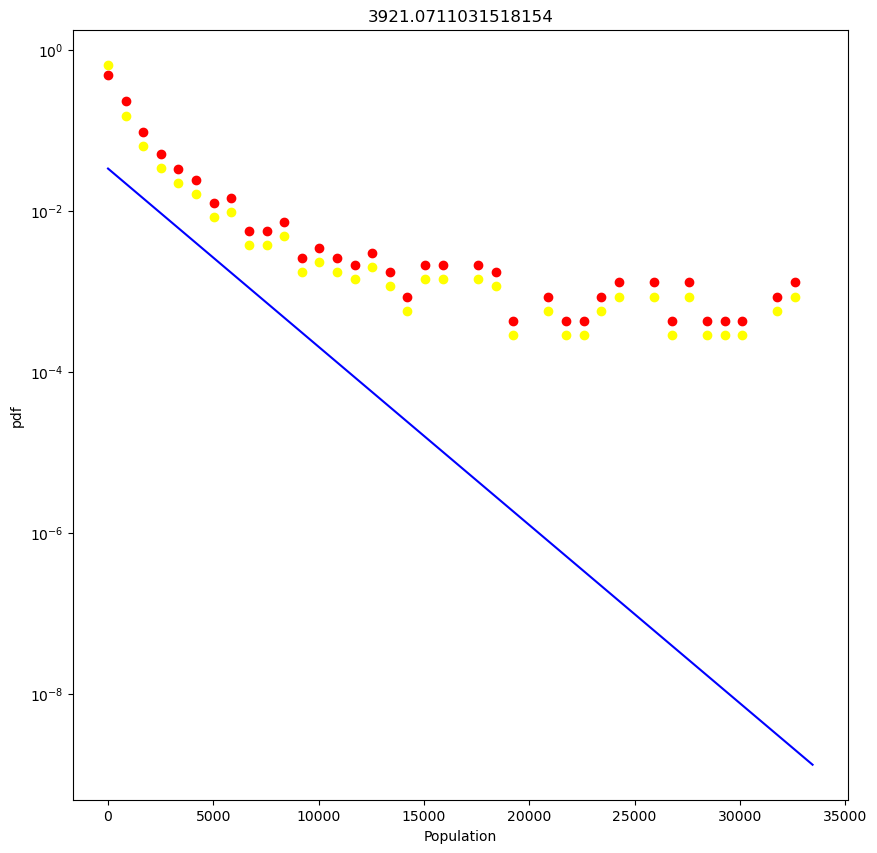

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1960,)

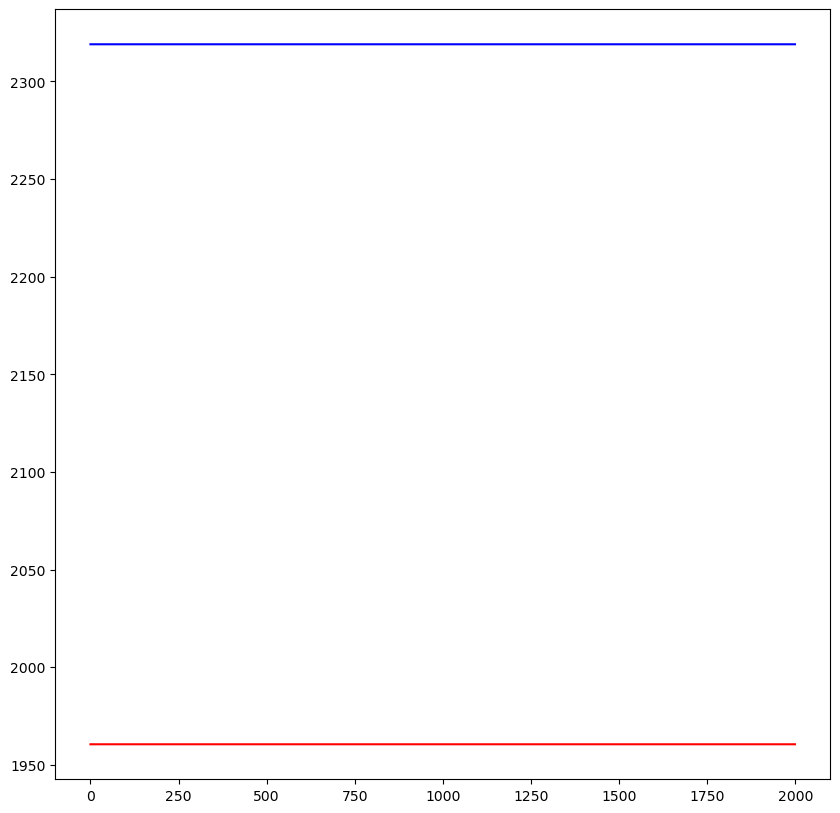

In [191]:
fractions = np.linspace(1,15,15)
r0 = 10
N = 2000 
for fraction in fractions:
    m01 = m0 + m0*fraction
    population, evolution_mean,evolution_number_centers,population_moved,evolution_population_moved = ReassignPopulationRandomly(grid, m0, r0, N) 
#    ReassignPopulationRandomly(grid, m0, fitplM['A'],fitplM['b'], 2000)
    PopChanged, PopChangedBins = np.histogram(population,40)
    PopChanged = PopChanged/np.sum(PopChanged)
    grid['changed_population'] = population
    fig,ax = plt.subplots(1,1,figsize = (12,12))
    SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black')
    grid_plot = grid.plot(column='changed_population', cmap='viridis', edgecolor='black', alpha=0.3, legend=True, ax=ax)
    ax.set_title('Population Boston Changed')
    plt.savefig(os.path.join(dir_grid,'populationBoston.png'),dpi = 200)    
    fig,ax = plt.subplots(1,1,figsize = (10,10))
    ax.scatter(PopDataBins[:-1],PopData,color = 'red',label = 'Data')
    ax.plot(PopBins,PopExpo,color = 'blue',label = 'Expo')
    ax.scatter(PopChangedBins[:-1],PopChanged,color = 'yellow', label = 'Changed Population')
    ax.set_xlabel('Population')
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_title('{}'.format(m01))
    plt.show()

    fig,ax = plt.subplots(1,1,figsize = (10,10))
    ax.plot(np.arange(len(evolution_mean)),evolution_mean,color = 'red',label = 'Mean')
    ax.plot(np.arange(len(evolution_number_centers)),evolution_number_centers,color = 'blue',label = 'Number Grids with People')
    ax.plot(np.arange(len(evolution_number_centers)),evolution_population_moved,color = 'yellow',label = 'Population Moved')
    ax.set_title('{}'.format(m01))
    ax.set_xlabel('Iteration')
    ax.set_yscale('log')
    ax.legend(['Mean Population','Number of Grids with People','Population Moved'])
    plt.show()


# GET Vec Field & Pot

In [54]:
ComputeInitPotential = True
ComputeInitVF = True
if ComputeInitVF:
    VectorField = GetVectorField(Tij,df_distance)
    VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))
    SaveVectorField(VectorField,VectorFieldDir)

if ComputeInitPotential:
    lattice = GetPotentialLattice(lattice,VectorField)
    lattice = SmoothPotential(lattice)
    PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
    PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)
    SavePotentialDataframe(PotentialDataframe,dir_grid)


# MODIFY  

In [ ]:
## TODO: Modify Population -> Compute Fluxes -> Get Vector Field -> Compute Modified Potential -> Compute Lorenz -> Compute OD

with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitFluxesParameters.json','r')as f:
    fitGLM = json.load(f)
p0 = fraction

Population = ModifyPop(Population)
Tij_modified = ComputeFluxesModifiedPopulation(Population) 
VectorField = ComputeVectorFieldModified(Tij,df_distance)
Potential = ComputePotentialModified(VectorField)

p = ComputeLorenzCurve(Potential)
OD_DemandFromFluxes()

# MODIFIED OD CREATION

In [ ]:
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/origindest2grid.json','r') as f:
    OD2grid = json.load(f)

with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/grid2origindest.json','r') as f:
    grid2OD = json.load(f)
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/osmid2idx.json') as f:
    osmid2index = json.load(f)

def CumulativeODFromGrid(O_vector,D_vector,OD_vector,osmid2index,grid2OD,start,multiplicative_factor,seconds_in_minute):
    total_number_people_considered = 0
    total_number_people_not_considered = 0
    count_line = 0
    users_id = []
    time_ = []
    origins = []
    destinations = []
    osmid_origin = []
    osmid_destination = []
    print('number of couples of origin-destination: ',len(O_vector))
    for i in range(len(O_vector)):
        origin = O_vector[i]
        destination = D_vector[i]
        number_people = OD_vector[i]
        bin_width = 1                        
        if number_people > 0:
            iterations = multiplicative_factor*number_people/bin_width   
            time_increment = 1/iterations
            for it in range(int(iterations)):
                try:
                    Originbigger0 = len(grid2OD[origin])>0
                except KeyError:
                    total_number_people_not_considered += number_people
                    break
                try:
                    Destinationbigger0 = len(grid2OD[destination])>0
                except KeyError:
                    total_number_people_not_considered += number_people
                    break
                if  Originbigger0 and Destinationbigger0:
                    users_id.append(count_line)
                    t = start*(seconds_in_minute**2) + it*time_increment*seconds_in_minute**2
                    time_.append(t) # TIME IN HOURS
                    i = np.random.randint(0,len(grid2OD[origin]))
                    try:
                        origins.append(osmid2index[grid2OD[origin][i]])
                    except KeyError:
                        total_number_people_not_considered += number_people
                        raise KeyError('KeyError Polygon 2 OD: origin {0} i {1}'.format(origin,i))
                    j = np.random.randint(0,len(grid2OD[destination]))                        
                    try:
                        destinations.append(osmid2index[grid2OD[destination][j]])
                    except KeyError:
                        total_number_people_not_considered += number_people
                        raise KeyError('KeyError Polygon 2 OD: destination {0} j {1}'.format(origin,i))
                    osmid_origin.append(grid2OD[origin][i])
                    osmid_destination.append(grid2OD[destination][j])
                    ## FILLING ORIGIN DESTINATION GRID ACCORDING TO THE ORIGIN DESTINATION NODES
                    count_line += 1
                    total_number_people_considered += 1
    print('total_number_people_considered: ',total_number_people_considered)
    print('total_number_people_not_considered: ',total_number_people_not_considered)
    print('ratio: ',total_number_people_considered/(total_number_people_considered+total_number_people_not_considered))
    return users_id,time_,origins,destinations,osmid_origin,osmid_destination

def OD_from_T_Modified(Tij_modified,
                       CityName2RminRmax,
                       NameCity,
                       osmid2index,
                       grid2OD,
                       p,
                       save_dir_local,
                       start = 7,
                       end = 8
                       ):
    ROutput = []
    # NOTE: ADD HERE THE POSSIBILITY OF HAVING OD FROM POTENTIAL CONSIDERATIONS
    O_vector = Tij_modified['origin']
    D_vector = Tij_modified['destination']
    OD_vector = Tij_modified['number_people']
    # START TAB
    R = np.sum(OD_vector)/3600 # R is the number of people that move in one second (that is the time interval for the evolution )
    Rmin = CityName2RminRmax[NameCity][0]
    Rmax = CityName2RminRmax[NameCity][1]
    spacing = (Rmax/R - Rmin/R)/20
    for multiplicative_factor in np.arange(Rmin/R,Rmax/R,spacing):
        R = np.sum(OD_vector)/3600 
        if os.path.isfile(os.path.join(save_dir_local,'OD','{0}_oddemand_{1}_{2}_R_{3}.csv'.format(NameCity,start,end,int(multiplicative_factor*R)))):
            cprint(os.path.join(save_dir_local,'OD','{0}_oddemand_{1}_{2}_R_{3}.csv'.format(NameCity,start,end,int(multiplicative_factor*R))),'cyan')
            ROutput.append(int(multiplicative_factor*R))
            continue
        else:
            cprint('COMPUTING {}'.format(os.path.join(save_dir_local,'OD','{0}_oddemand_{1}_{2}_R_{3}.csv'.format(NameCity,start,end,int(multiplicative_factor*R)))),'cyan')
            users_id,time_,origins,destinations,osmid_origin,osmid_destination = CumulativeODFromGrid(O_vector,D_vector,OD_vector,osmid2index,grid2OD,start,multiplicative_factor,60)
            df1 = pd.DataFrame({
                'SAMPN':users_id,
                'PERNO':users_id,
                'origin_osmid':osmid_origin,
                'destination_osmid':osmid_destination,
                'dep_time':time_,
                'origin':origins,
                'destination':destinations,
                })
            print('df1:\n',df1.head())
            R = multiplicative_factor*R
            ROutput.append(int(R))
            df1.to_csv('')
    
